In [1]:
import pandas as pd
import epipi
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
# import rpy2.robjects as robjects

In [2]:
# Data Preparation
omega = pd.read_csv('../EpiOS/omega.csv')['omega'].values
theta = pd.read_csv('../EpiOS/y_interpolated.csv')['y_interpolated'].values
incidences_true = pd.read_csv('../EpiOS/incidences_true.csv')['incidences_true'].values

## Use PyStan with kernel at the end of time sample

In [ ]:
prior = []
for i in range(len(theta)):
    prior.append(epipi.NormalPrior(1000, 200))
prior.append(epipi.NormalPrior(0, 1))

In [26]:
kernel = [0, 0, 0]
starting_time_point = 0
end_time_point = len(theta)
controller = epipi.InferenceController(theta[starting_time_point:end_time_point], omega, kernel=kernel)
fit, samples = controller.run()
df = az.summary(samples)
df

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
I[0],250.581,14.509,222.626,276.566,0.235,0.166,3894.0,2890.0,1.0
I[1],14.067,12.680,0.017,37.649,0.210,0.151,3033.0,2070.0,1.0
I[2],24.847,18.749,0.022,58.573,0.320,0.226,2702.0,1707.0,1.0
I[3],61.991,31.695,1.642,114.105,0.596,0.422,2577.0,1403.0,1.0
I[4],98.183,41.871,16.583,169.374,0.908,0.642,1749.0,819.0,1.0
...,...,...,...,...,...,...,...,...,...
I[78],1.939,1.941,0.000,5.556,0.025,0.021,4368.0,2222.0,1.0
I[79],2.038,1.971,0.002,5.687,0.025,0.021,4211.0,2257.0,1.0
I[80],2.532,2.469,0.001,7.102,0.030,0.026,4374.0,1772.0,1.0
I[81],3.638,3.535,0.000,10.045,0.045,0.038,3191.0,1598.0,1.0


Mean R_hat is 1.0
Std R_hat is 0.0


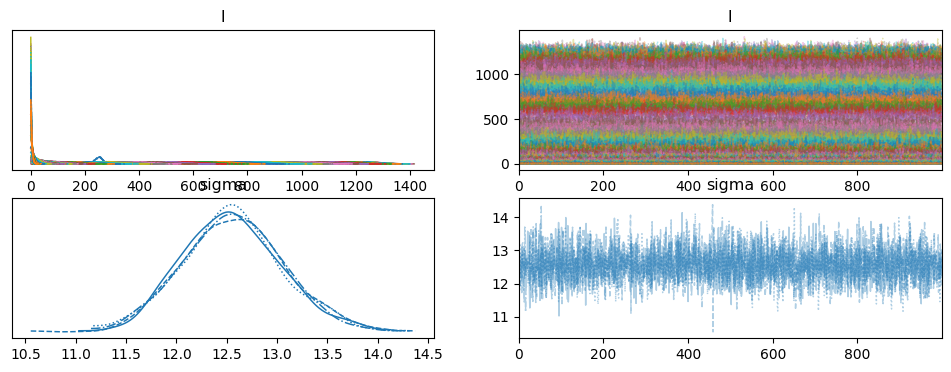

In [27]:
az.plot_trace(samples)
print('Mean R_hat is', df['r_hat'].values.mean())
print('Std R_hat is', df['r_hat'].values.std())

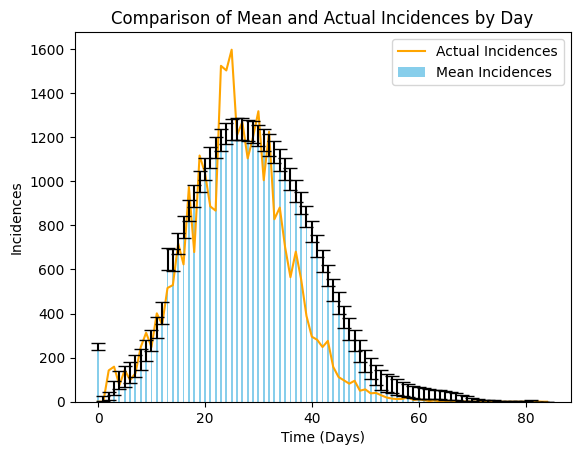

In [28]:
pre_I = np.array(list(df['mean'].values[:-1]) + kernel)
pre_std = np.array(list(df['sd'].values[:-1]) + [0, 0, 0])
plt.plot(range(starting_time_point, end_time_point), incidences_true[starting_time_point:end_time_point], color='orange', label='Actual Incidences')
plt.bar(range(starting_time_point, end_time_point), pre_I, yerr=pre_std, color='skyblue', capsize=5, label='Mean Incidences', width=0.35)
# Adding details
plt.xlabel('Time (Days)')
plt.ylabel('Incidences')
plt.title('Comparison of Mean and Actual Incidences by Day')
plt.legend()
plt.show()

## Use RStan to implement optimization methods

In [4]:
controller = epipi.OptimizerController(theta, omega)
result = controller.run()

R[write to console]: Error in library(rstan) : there is no package called ‘rstan’



RRuntimeError: Error in library(rstan) : there is no package called ‘rstan’


In [4]:
robjects.r("""library(rstan)""")

R[write to console]: Error in library(rstan) : there is no package called ‘rstan’



RRuntimeError: Error in library(rstan) : there is no package called ‘rstan’


In [3]:
mkdir -p ~/R/x86_64-pc-linux-gnu-library/4.3.3
Rscript -e "install.packages('rstan', repos = 'https://cloud.r-project.org/', dependencies = TRUE, lib='~/R/x86_64-pc-linux-gnu-library/4.3.3')"
Sys.setenv(DOWNLOAD_STATIC_LIBV8 = 1) # only necessary for Linux without the nodejs library / headers

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: Warning in install.packages("rstan", repos = c("https://mc-stan.org/r-packages/",  :
R[write to console]: 
 
R[write to console]:  'lib = "/usr/local/lib/R/site-library"' is not writable

